## Create and test ion channel model

In [5]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_recov,
                                        sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

In [6]:
modelfile = 'models/nygren_Na.mmt'

In [7]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_iv_Nao2 ,
                                                sakakibara_iv_Nao5 ,
                                                sakakibara_iv_Nao20 ,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,
                                                sakakibara_inact_kin_2,
                                                sakakibara_recov,
                                                sakakibara_recov_kin)

In [8]:
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [9]:

#
#'membrane.Cm' : (0.0001,1), # keep it off 
limits = { 'ina.s1' : (0,1),
          
          'ina.P_Na' : (0.000001,0.05),
          'ina.q1': (0,100),
          'ina.q2': (0,100),
          'ina.r1': (0,100),
          'ina.r2': (-50,50),
          'ina.q3': (0,20),
          'ina.q4': (20,80),
          'ina.q5': (-25,25),
          'ina.q6': (0,20),
          'ina.q7': (0,20),
          'ina.q8': (0,20),
          'ina.r3': (0,1),
          'ina.r4': (0,100),
          'ina.r5': (0,100),
          'ina.r6': (0,0.01)}
"""
limits = {'ina.P_Na' : (0.000001,0.05),
          'ina.q1': (0,100),
          'ina.q2': (0,100),
          'ina.r1': (0,100),
          'ina.r2': (-50,50)}
"""
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [10]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "nygren_ina_testing.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 65536 particles


In [13]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(100), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9617686805272357, '1': 0.9617686805272357, '2': 0.9617686805272357, '3': 0.9617686805272357, '4': 0.9617686805272357, '5': 0.9617686805272357, '6': 0.9617686805272357, '7': 0.9617686805272357, '8': 0.9617686805272357, '9': 0.9617686805272357, '10': 0.9617686805272357, '11': 0.9617686805272357, '12': 0.9617686805272357, '13': 0.9617686805272357, '14': 0.9617686805272357, '15': 0.9617686805272357, '16': 0.9617686805272357, '17': 0.9617686805272357, '18': 0.9617686805272357, '19': 0.9617686805272357, '20': 0.9617686805272357, '21': 0.9617686805272357, '22': 0.9617686805272357, '23': 0.9617686805272357, '24': 0.9617686805272357, '25': 0.9617686805272357, '26': 0.9617686805272357, '27': 0.9617686805272357, '28': 0.9617686805272357, '29': 0.9617686805272357, '30': 0.9617686805272357, '31': 0.9617686805272357, '32': 0.9617686805272357, '33': 0.9617686805272357, '34': 0.9617686805272357, '35': 0.9617686805272357, '36': 0.9617686805272357, '37': 0.96176868

In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
#abc.load(db_path,41)

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=42, start_time=2019-08-12 15:19:26.806806, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=3, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 3309
DEBUG:Epsilon:new eps, t=1, eps=11.940197094622457
INFO:ABC:t:1 eps:11.940197094622457
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done


# Results analysis

In [1]:
history.all_runs()

NameError: name 'history' is not defined

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

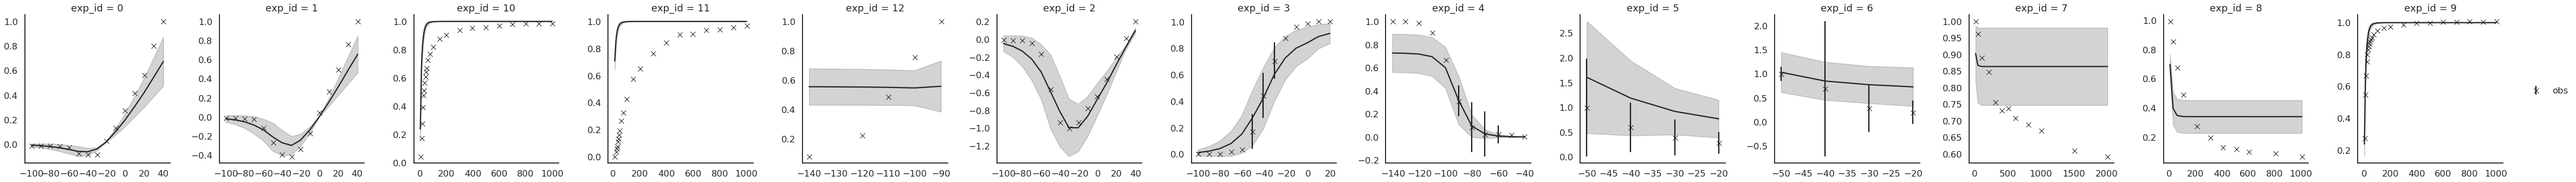

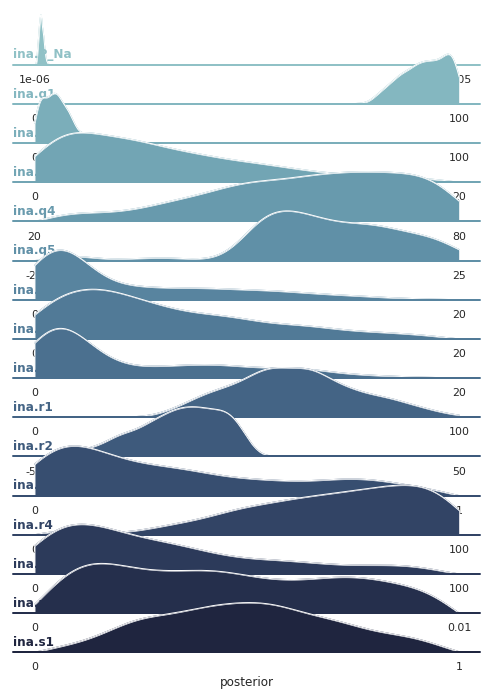

In [19]:
history = History(db_path)
history.id = 41 
df, w = history.get_distribution(m=0)

# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')
plotting_obs = observations.copy()

# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(model(th))
    output = pd.DataFrame({'x': plotting_obs.x, 'y': list(results.values()),
                           'exp_id': plotting_obs.exp_id})
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

sns.set_context('talk')


grid1 = plot_sim_results(samples, obs=plotting_obs)
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [20]:
grid1.savefig('../results/ina/nygren/ina_nygren_posterior_sakakibara_exp_pop_10000.pdf')
grid2.savefig('../results/ina/nygren/ina_nygren_experiments_sakakibara_exp_pop_10000.pdf')